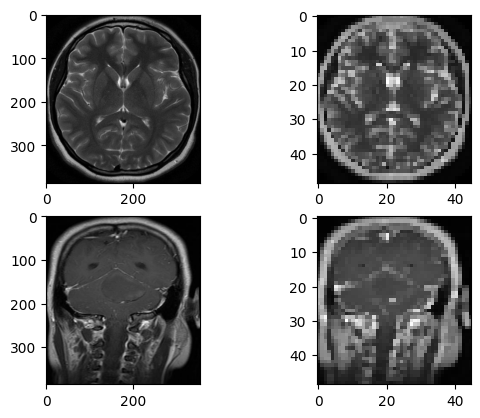

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import skimage.measure as ski
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1

tumorless = []
for file_name in os.listdir("..\\data\\brain_tumor_dataset\\no"):
        if file_name.lower().endswith(('.jpeg', '.jpg', '.png')):
            file_path = os.path.join("..\\data\\brain_tumor_dataset\\no\\", file_name)
            try:
                img = Image.open(file_path).convert('L')
                # center brain
                image_array = np.array(img)
                _, binary_mask = cv2.threshold(image_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                    # Crop the image to the bounding box of the brain
                    cropped_array = image_array[y:y+h, x:x+w]
                else:
                    # If no contours are found, return the original image
                    cropped_array = image_array
                cropped_image = Image.fromarray(cropped_array)
                tumorless.append(np.array(cropped_image.resize((354, 386), Image.Resampling.LANCZOS)))
            except Exception as e:
                print(f"Error loading image {file_name}: {e}")

tumor = []
for file_name in os.listdir("..\\data\\brain_tumor_dataset\\yes"):
        if file_name.lower().endswith(('.jpeg', '.jpg', '.png')):
            file_path = os.path.join("..\\data\\brain_tumor_dataset\\yes\\", file_name)
            try:
                img = Image.open(file_path).convert('L')
                # center brain
                image_array = np.array(img)
                _, binary_mask = cv2.threshold(image_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                    # Crop the image to the bounding box of the brain
                    cropped_array = image_array[y:y+h, x:x+w]
                else:
                    # If no contours are found, return the original image
                    cropped_array = image_array
                cropped_image = Image.fromarray(cropped_array)
                tumor.append(np.array(cropped_image.resize((354, 386), Image.Resampling.LANCZOS)))
            except Exception as e:
                print(f"Error loading image {file_name}: {e}")

plt.subplot(2, 2, 1)
# plot raw tumorless image
plt.imshow(tumorless[0], cmap='gray')

# compress image
plt.subplot(2, 2, 2)
maxpool_tumorless = ski.block_reduce(tumorless[0], (8,8), np.max)
plt.imshow(maxpool_tumorless, cmap='gray')

plt.subplot(2, 2, 3)

# plot raw tumor image
plt.imshow(tumor[3], cmap='gray')

# compress image
plt.subplot(2, 2, 4)
maxpool_tumor = ski.block_reduce(tumor[3], (8,8), np.max)   
plt.imshow(maxpool_tumor, cmap='gray')

Reading images from ..\data\brain_tumor_dataset into a structured format


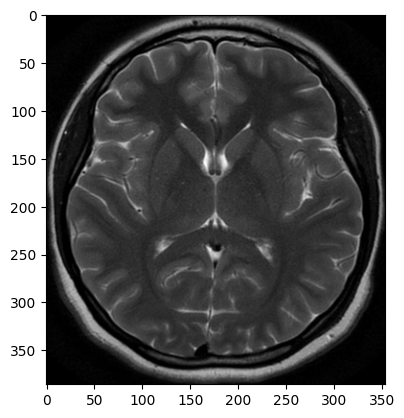

In [37]:
import matplotlib.pyplot as plt
from pathlib import Path
import sys

sys.path.append(str(Path().resolve().parent))

from utils import datautils

raw_data = datautils.read_resize_images("..\\data\\brain_tumor_dataset", verbose=True)

plt.imshow(raw_data[0]["image"], cmap='gray')

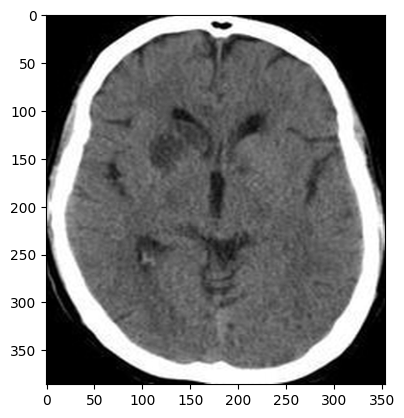

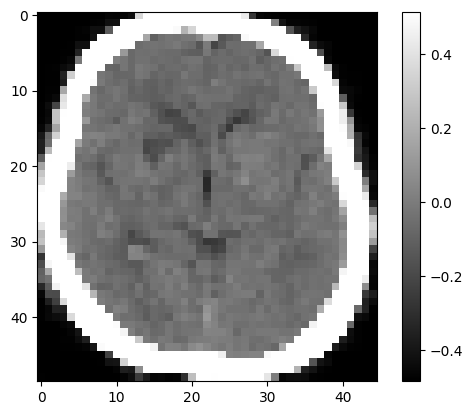

In [38]:
processed_data = []

for entry in raw_data:
        processed_entry = entry.copy()
        # reduce
        processed_entry["image"] = ski.block_reduce(entry["image"], (8, 8), np.max)
        # zero center
        mean_pixel_value = np.mean(processed_entry["image"])
        processed_entry["image"] = processed_entry["image"] - mean_pixel_value
        # normalize
        processed_entry["image"] = (processed_entry["image"] / 255.0).astype(np.float32)
        processed_data.append(processed_entry)
plt.imshow(raw_data[201]["image"], cmap='gray')
plt.show()
plt.imshow(processed_data[201]["image"], cmap='gray')
plt.colorbar()

In [48]:
X_train, X_test, X_val, y_train, y_test, y_val = datautils.shuffle_split(processed_data, split=0.2)

Training set size: 4365
Validation set size: 1455
Test set size: 1456


In [49]:
input_shape = (49, 45, 1)
num_classes = 1
initializer = tf.keras.initializers.GlorotUniform()

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1(0.01), input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l1(0.01)),
    Dropout(0.5),
    Dense(units=num_classes, activation='sigmoid', kernel_initializer=initializer)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 47, 43, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 47, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 23, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 23, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 21, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 21, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 10, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 10, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 8, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 4, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 4, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,001 (750.00 KB)

 Trainable params: 191,553 (748.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.9188 - loss: 0.7643 - val_accuracy: 0.8605 - val_loss: 0.8132
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.9292 - loss: 0.6985 - val_accuracy: 0.9402 - val_loss: 0.6765
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.9274 - loss: 0.7237 - val_accuracy: 0.9258 - val_loss: 0.7158
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.9249 - loss: 0.7238 - val_accuracy: 0.9299 - val_loss: 0.6822
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9311 - loss: 0.6472 - val_accuracy: 0.9127 - val_loss: 0.6818
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9306 - loss: 0.6484 - val_accuracy: 0.9292 - val_loss: 0.6520
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9244 - loss: 0.6532 - val_accuracy: 0.9313 - val_loss: 0.6194
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9326 - loss: 0.6

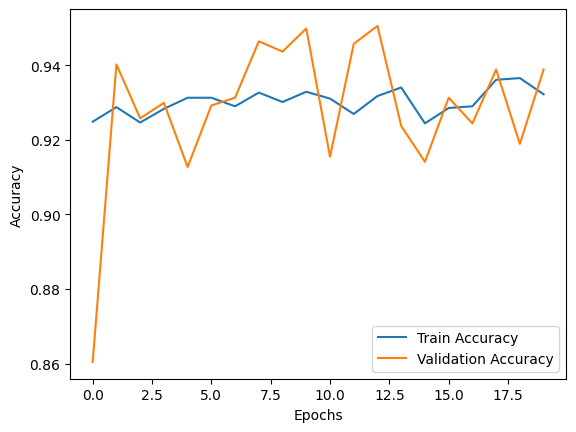

In [53]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9347 - loss: 0.7125
Test Loss: 0.6894237995147705
Test Accuracy: 0.9443681240081787
